In [222]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator
from statsmodels.stats.proportion import proportion_confint
import math
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "/home/michaelswift/repos/tabula-bursa/analysis/figures/in_vitro_ASC"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')


Duplicate key in file '../bursa.mplstyle', line 23 ('axes.edgecolor : black   # Axes edge color (spines)')


In [210]:
%run ../helper.py

# 

In [3]:
adata = sc.read_h5ad("../../../data/in_vitro_bcells.h5ad.gz")
adata.obs_names_make_unique(join="_")

In [5]:
bcell_data = adata.obs
bcell_data['bcelltype'] = bcell_data['celltypist']
bcell_data['in_vitro_stim'] = bcell_data['sample_id'].isin(["Day 4", "Day 8", "Day 12"])
# Combine "Plasmablasts" and "Plasma cells" into "ASC"
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Plasmablasts', 'Plasma cells'], 'ASCs')
#bcell_data['bcelltype'] = bcell_data['bcelltype'].replace('Memory B cells', 'Mem')
# Combine "proliferative" and "germinal center" into "GC B cells"
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Proliferative germinal center B cells'], 'GC B cells')

In [10]:
bcell_data = bcell_data[bcell_data.v_mismatch > 0]

In [33]:
bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins=bin_edges)

/tmp/ipykernel_65883/4252442630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins=bin_edges)


In [168]:
# Ensure 'v_mismatch' column is free of NaN values or fill them with a default integer value
bcell_data['v_mismatch'] = bcell_data['v_mismatch'].fillna(0) # or some other appropriate fill value

# Attempt to convert 'v_mismatch' to integers, catching any errors that may arise
try:
    bcell_data['v_mismatch'] = bcell_data['v_mismatch'].astype(int)
except ValueError as e:
    print(f"Conversion failed: {e}")
    # Optionally, inspect non-convertible entries
    non_ints = bcell_data['v_mismatch'][~bcell_data['v_mismatch'].apply(lambda x: x.is_integer())]
    print(non_ints)

/tmp/ipykernel_65883/1650517211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['v_mismatch'] = bcell_data['v_mismatch'].fillna(0) # or some other appropriate fill value
/tmp/ipykernel_65883/1650517211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['v_mismatch'] = bcell_data['v_mismatch'].astype(int)


In [174]:
# Find the min and max of the v_mismatch data to determine the bin range
min_v_mismatch = bcell_data['v_mismatch'].min()
max_v_mismatch = bcell_data['v_mismatch'].max()

# Generate bins from the min to max with a step of 1 (integer bins)
bins = 17
bins = np.arange(0,46,5)
bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins = bins, include_lowest=True)

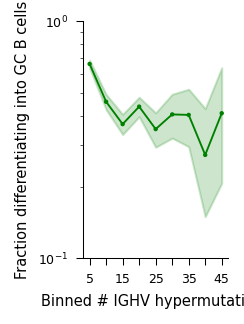

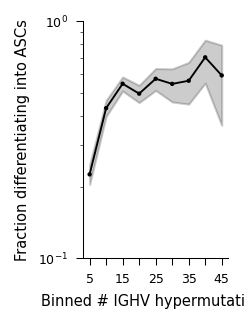

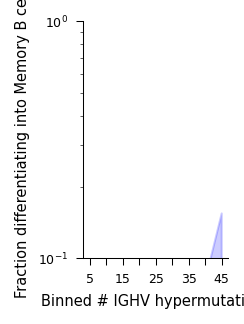

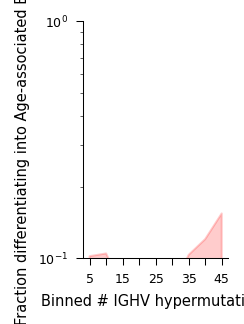

In [230]:
# function to calculate the fraction and confidence interval
def calculate_fraction_and_ci(group, celltype):
    count_celltype = (group['bcelltype'] == celltype).sum()
    n_total = len(group)
    fraction_celltype = count_celltype / n_total
    lower, upper = proportion_confint(count_celltype, n_total, alpha=0.05, method='beta')
    return pd.Series({f'fraction_{celltype}': fraction_celltype, 'lower_ci': lower, 'upper_ci': upper, 'total_cells_in_bin': n_total})

# List of cell types interested in
celltypes = ["GC B cells", "ASCs", "Memory B cells"]
# filter out bins that have very few cells
filter_bins = True
n_cells = 10
# Dictionary to store color information for each cell type
celltypes_dict = {
    "GC B cells": 'green',
    "ASCs": 'black',
    "Memory B cells": 'blue',
    "Age-associated B cells": 'red'
}



for celltype in celltypes_dict.keys():
    grouped = bcell_data.groupby(['bin', 'in_vitro_stim'])
    fractions_per_sample = grouped.apply(lambda group: calculate_fraction_and_ci(group, celltype)).reset_index()
    fractions_per_sample = fractions_per_sample[fractions_per_sample.in_vitro_stim == True]
    if filter_bins:
        fractions_per_sample = fractions_per_sample[fractions_per_sample['total_cells_in_bin'] >= n_cells]
    # Extract the right edge and round it to the nearest integer for labeling
    fractions_per_sample['bin_label'] = fractions_per_sample['bin'].apply(lambda x: str(int(math.floor(x.right))))
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(1.25, 2.05))
    points_plot = sns.pointplot(data=fractions_per_sample, x='bin_label', y=f'fraction_{celltype}', errorbar=None, color=celltypes_dict[celltype], join=True, scale = 0.5)
    
    # Manually adjust the size of the points to 0
    for point in points_plot.collections:
        point.set_sizes([2])
    ax.set_yscale('log')
    # Set y-axis minor ticks but disable minor tick labels
    ax.yaxis.set_minor_locator(plt.LogLocator(subs='auto'))
    ax.tick_params(axis='y', which='minor', length=1.5)
    ax.tick_params(axis='y', which='minor', labelleft=False)
    # Manually add the filled error bars using plt.fill_between
    x_values = range(len(fractions_per_sample))
    ax.fill_between(x_values, fractions_per_sample['lower_ci'], fractions_per_sample['upper_ci'], color=celltypes_dict[celltype], alpha=0.2)
        # Remove every other xticklabel
        # Remove every second xticklabel starting from the first
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        if i % 2 == 1:  # This will hide the second label, fourth label, and so on
            label.set_visible(False)
    ax.set_xlabel('Binned # IGHV hypermutations')
    ax.set_ylabel(f'Fraction differentiating into {celltype}')
    sns.despine()
    ax.set_ylim(0.1, 1)
    plt.gca().xaxis.set_minor_locator(NullLocator())
    save_figure(fig, f"v_mismatch_diff_chance_{celltype.replace(' ', '_')}")